<h3> Imports

In [58]:
import numpy as np
import pandas as pd
import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import to_categorical, plot_model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from skimage.transform import resize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
print("GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)
print(sys.version)
print(tf.test.gpu_device_name())
print(tf.test.is_gpu_available())

GPUs Available:  1
True
2.6.2
3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
/device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


<h3> EDA & Preprocessing

In [81]:
class CFG:
    batch_size = 64
    img_shape = 96
    epoch = 25
    layer_trainable = True
    optimizer = "adam"

In [82]:
train_path = "data/train/"
test_path = "data/test"
emotions = os.listdir(train_path)
len_train = {}
len_test = {}

for emotion in emotions:
    file_train = os.listdir(os.path.join(train_path, emotion))
    len_train[emotion] = len(file_train)
    
    file_test = os.listdir(os.path.join(test_path, emotion))
    len_test[emotion] = len(file_test)

print("Train: ", len_train)
print("Test: ", len_test)

total_train = sum(len_train.values())
total_test = sum(len_test.values())

print()
print("Total Train: ", total_train)
print("Total Test: ", total_test)

Train:  {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Test:  {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1772, 'neutral': 1232, 'sad': 1247, 'surprise': 832}

Total Train:  28709
Total Test:  7176


In [83]:
# Class Distribution

data_split = ["Train", "Test"]
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=data_split
)

all_len = [len_train, len_test]
all_total = [total_train, total_test]

for i in range(2):
    # Bar Chart
    fig.add_trace(
        go.Bar(
            x=list(all_len[i].keys()),
            y=list(all_len[i].values()),
            name=data_split[i],
            marker_color=["#935d39", "#926f48", "#90825c", "#8e9590", "#8ba0a5", "#88acb9", "#85b8cd"],
        ), row=i+1, col=1
    )

    # Update Axes
    fig.update_xaxes(ticks="outside", linecolor="Black", row=i+1, col=1)
    fig.update_yaxes(ticks="outside", linecolor="Black", row=i+1, col=1)

# Update Layout
fig.update_layout(
    title="Class Distribution",
    width=450, height=700,
    plot_bgcolor="White",
    showlegend=False
)

fig.show()

In [84]:
augmented_train_path = "data/augmented_train/"
emotions = os.listdir(augmented_train_path)
len_augmented_train = {}

for emotion in emotions:
    file_train = os.listdir(os.path.join(augmented_train_path, emotion))
    len_augmented_train[emotion] = len(file_train)


print("Augmented Train: ", len_augmented_train)

total_augmented_train = sum(len_augmented_train.values())

print()
print("Total Augmented Train: ", total_augmented_train)

Augmented Train:  {'angry': 7957, 'disgust': 2716, 'fear': 8191, 'happy': 13715, 'neutral': 9923, 'sad': 9691, 'surprise': 6372}

Total Augmented Train:  58565


In [85]:
# Class Distribution

data_split = ["Train", "Augmented Train"]
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=data_split
)

all_len = [len_train, len_augmented_train]
all_total = [total_train, total_augmented_train]

for i in range(2):
    # Bar Chart
    fig.add_trace(
        go.Bar(
            x=list(all_len[i].keys()),
            y=list(all_len[i].values()),
            name=data_split[i],
            marker_color=["#935d39", "#926f48", "#90825c", "#8e9590", "#8ba0a5", "#88acb9", "#85b8cd"],
        ), row=i+1, col=1
    )

    # Update Axes
    fig.update_xaxes(ticks="outside", linecolor="Black", row=i+1, col=1)
    fig.update_yaxes(ticks="outside", linecolor="Black", row=i+1, col=1)

# Update Layout
fig.update_layout(
    title="Class Distribution",
    width=450, height=700,
    plot_bgcolor="White",
    showlegend=False
)

fig.show()

In [86]:
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode="nearest",
    validation_split = 0.2
)
train_generator = train_datagen.flow_from_directory(
#     directory = "data/train/",
    directory = "data/augmented_train/",
    save_format="jpg",
    target_size = (CFG.img_shape,CFG.img_shape),
    batch_size = CFG.batch_size,
    class_mode = "categorical",
    subset = "training"
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2
)

validation_generator = validation_datagen.flow_from_directory(
    directory = "data/test/",
    target_size = (CFG.img_shape,CFG.img_shape),
    batch_size = CFG.batch_size,
    class_mode = "categorical",
    subset = "validation"
)
print("done")

Found 46854 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
done


In [87]:
batch_x, batch_y = next(train_generator)

# Check label type (one hot encoded or label embedded)
print("Shape of labels:", batch_y.shape)
print(batch_y)
# y is one hot encoded so we will use categorical_crossentropy 

Shape of labels: (64, 7)
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0

shape:  (48, 48, 3)


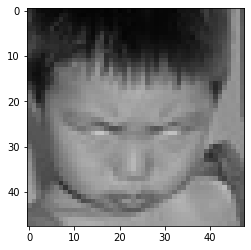

In [88]:
img_array = cv2.imread("data/train/angry/angry_1.jpg")
print("shape: ", img_array.shape) # rgb
plt.imshow(img_array)
#its very pixilated because the size of the image is 48x48

shape:  (96, 96, 3)


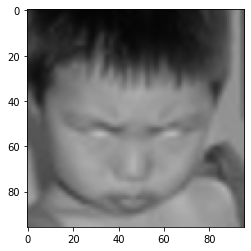

In [89]:
#change size of image
resized_img_array = cv2.resize(img_array, (CFG.img_shape,CFG.img_shape))
plt.imshow(cv2.cvtColor(resized_img_array, cv2.COLOR_BGR2RGB))
print("shape: ", resized_img_array.shape) # rgb

In [90]:
input_shape = (CFG.img_shape, CFG.img_shape, 3)
base_model = MobileNetV2(weights="imagenet",  include_top=False, input_shape=input_shape)

#freeze weights
for layer in base_model.layers:
    layer.trainable=CFG.layer_trainable

base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [91]:
#add my own layers
base_input = base_model.input
base_output = base_model.output
############
# TRY ONE
# final_output = layers.Dense(128)(base_output)
# final_output = layers.Activation('relu')(final_output)
# final_output = layers.Dense(64)(final_output)
# final_output = layers.Activation('relu')(final_output)
# final_output = GlobalAveragePooling2D()(final_output)
###########
# TRY TWO
# final_output = layers.Dropout(0.5)(base_output)
# final_output = layers.Flatten()(final_output)
# final_output = layers.BatchNormalization()(final_output)
# final_output = layers.Dense(32,kernel_initializer='he_uniform')(final_output)
# final_output = layers.BatchNormalization()(final_output)
# final_output = layers.Activation('relu')(final_output)
# final_output = layers.Dropout(0.5)(final_output)
# final_output = layers.Dense(32,kernel_initializer='he_uniform')(final_output)
# final_output = layers.BatchNormalization()(final_output)
# final_output = layers.Activation('relu')(final_output)
# final_output = layers.Dropout(0.5)(final_output)
# final_output = layers.Dense(32,kernel_initializer='he_uniform')(final_output)
# final_output = layers.BatchNormalization()(final_output)
# final_output = layers.Activation('relu')(final_output)

final_output_prediction = Dense(7, activation="softmax")(final_output)

new_model = keras.Model(inputs= base_input, outputs= final_output_prediction)
new_model.compile(
    loss='categorical_crossentropy', 
    optimizer=CFG.optimizer, 
    metrics=['accuracy']
)

new_model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "Conv1". The following previous layers were accessed without issue: []

In [72]:
#Callback
model_checkpoint = ModelCheckpoint(
    "model_checkpoints/new_models/mobilenet-adam-categorical_crossentropy-loss_{val_loss:.4f}-accuracy_{val_accuracy:.4f}.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=CFG.epoch * 0.1,
    restore_best_weights=True,
    verbose=1)


callbacks = [model_checkpoint, early_stopping_callback]

In [73]:
%%time
history = new_model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // CFG.batch_size,
    epochs=CFG.epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=callbacks
)

Epoch 1/50
732/732 [==============================] - 293s 394ms/step - loss: 1.4088 - accuracy: 0.4859 - val_loss: 1.3270 - val_accuracy: 0.5135

Epoch 00001: val_loss improved from inf to 1.32698, saving model to model_checkpoints/new_models\mobilenet-adam-categorical_crossentropy-loss_1.3270-accuracy_0.5135.h5


D:\Anaconda\envs\cuda_tf\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/50
732/732 [==============================] - 139s 186ms/step - loss: 1.2746 - accuracy: 0.5445 - val_loss: 1.4272 - val_accuracy: 0.4865

Epoch 00002: val_loss did not improve from 1.32698
Epoch 3/50
732/732 [==============================] - 137s 187ms/step - loss: 1.2378 - accuracy: 0.5610 - val_loss: 1.2631 - val_accuracy: 0.5426

Epoch 00003: val_loss improved from 1.32698 to 1.26313, saving model to model_checkpoints/new_models\mobilenet-adam-categorical_crossentropy-loss_1.2631-accuracy_0.5426.h5
Epoch 4/50
732/732 [==============================] - 140s 191ms/step - loss: 1.2207 - accuracy: 0.5641 - val_loss: 1.2028 - val_accuracy: 0.5526

Epoch 00004: val_loss improved from 1.26313 to 1.20284, saving model to model_checkpoints/new_models\mobilenet-adam-categorical_crossentropy-loss_1.2028-accuracy_0.5526.h5
Epoch 5/50
732/732 [==============================] - 141s 193ms/step - loss: 1.2003 - accuracy: 0.5717 - val_loss: 1.0869 - val_accuracy: 0.6115

Epoch 00005: val_

<h3> Evaluation Metrics

In [74]:
train_loss, train_accuracy = new_model.evaluate(train_generator)
test_loss, test_accuracy   = new_model.evaluate(validation_generator)

23/23 [==============================] - 1s 41ms/step - loss: 1.0676 - accuracy: 0.6047


In [75]:
predictions = new_model.predict(validation_generator, steps=len(validation_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

In [76]:
# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Accuracy: 0.1920391061452514
Precision: 0.1915532661307595
Recall: 0.1920391061452514
F1 Score: 0.18199451867358168

Classification Report:
              precision    recall  f1-score   support

       angry       0.15      0.25      0.19       191
     disgust       0.00      0.00      0.00        22
        fear       0.14      0.06      0.08       204
       happy       0.25      0.24      0.25       354
     neutral       0.21      0.33      0.25       246
         sad       0.21      0.10      0.14       249
    surprise       0.14      0.16      0.15       166

    accuracy                           0.19      1432
   macro avg       0.16      0.16      0.15      1432
weighted avg       0.19      0.19      0.18      1432



In [77]:
# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Accuracy: 0.1920391061452514
Precision: 0.1915532661307595
Recall: 0.1920391061452514
F1 Score: 0.18199451867358168

Classification Report:
              precision    recall  f1-score   support

       angry       0.15      0.25      0.19       191
     disgust       0.00      0.00      0.00        22
        fear       0.14      0.06      0.08       204
       happy       0.25      0.24      0.25       354
     neutral       0.21      0.33      0.25       246
         sad       0.21      0.10      0.14       249
    surprise       0.14      0.16      0.15       166

    accuracy                           0.19      1432
   macro avg       0.16      0.16      0.15      1432
weighted avg       0.19      0.19      0.18      1432



In [78]:
# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color="#935d39", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="#935d39", width=1.5),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color="#85b8cd", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="#85b8cd", width=1.5),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color="#935d39", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="#935d39", width=1.5),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color="#85b8cd", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="#85b8cd", width=1.5),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training and Validation Results", title_x=0.5, font_family="Cambria",
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [79]:
true_labels = validation_generator.classes
predictions = new_model.predict(validation_generator)

confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=7)

print(confusion_matrix)

tf.Tensor(
[[36  2 12 42 58 15 26]
 [ 2  1  1  4  8  2  4]
 [43  1 11 45 52 18 34]
 [76  2 26 87 91 36 36]
 [49  0 10 57 73 22 35]
 [55  2 16 59 71 16 30]
 [46  2  7 41 35 10 25]], shape=(7, 7), dtype=int32)


In [80]:
# Confusion Matrix 2

# Create Figure
fig = go.Figure()

# Heatmap
emotion = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
fig.add_trace(
    go.Heatmap(
        z = confusion_matrix,
        x = emotion,
        y = emotion,
        text=confusion_matrix,
        textfont={"size":18},
        texttemplate="<b>%{text}</b>",
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>")
fig.update_yaxes(title="<b>Actual Values</b>")

# Update Layout
fig.update_layout(title_text='Confusion Matrix',
                  width=500, 
                  height=520,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [28]:
from keras.preprocessing import image
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
def predicion(url):
    img = image.load_img(url,target_size = (CFG.img_shape,CFG.img_shape))
    plt.imshow(img)
    img = np.array(img)
    img = img/255
    img = np.expand_dims(img,axis = 0)
    result = new_model.predict(img)
    result = list(result[0])
    print(result)
    predictions =  label_dict[np.argmax(result)]
    return predictions

[0.016131274, 0.000103521175, 0.043762986, 0.017393252, 0.001404832, 0.001484717, 0.9197194]


'Surprise'

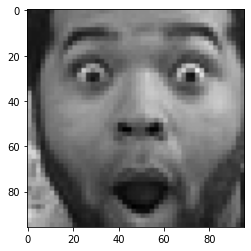

In [33]:
predicion("data/test/surprise/surprise_120.jpg")

<h3> Live Images

<h3> Before Changing

In [ ]:
# def preprocess_data(folder_path):
#     key_list = list(len_train.keys())
    
#     collected_data = [] #len_train.keys()
#     for category in key_list:
#         path = os.path.join(folder_path, category)
#         class_label = key_list.index(category)
#         for img in os.listdir(path):
#             #get array
#             img_array = cv2.imread(os.path.join(path, img))
            
#             collected_data.append([img_array, class_label])
#     return collected_data
# train_data = preprocess_data("data/train/")
# print("done preprocessing data")

# train_x = []
# train_y = []

# #train data
# for features,label in train_data:
#     train_x.append(features)
#     train_y.append(label)
    
# train_x = np.array(train_x)
# train_y = np.array(train_y)
# print(train_x.shape, train_y.shape)

# print("done splitting data")

In [ ]:
# def rename_files(folder_path, new_name):
#     file_list = os.listdir(folder_path)
#     file_count = len(file_list)
    
#     for i, filename in enumerate(file_list):
#         extension = os.path.splitext(filename)[1]  # Get the file extension
#         new_filename = f"{new_name}_{i+1}{extension}"  # Create the new filename with an auto-incremented ID
#         old_filepath = os.path.join(folder_path, filename)
#         new_filepath = os.path.join(folder_path, new_filename)
#         os.rename(old_filepath, new_filepath)
#         print(f"Renamed {filename} to {new_filename}")

# angry_dir = os.path.join("data/test", "angry")
# disgust_dir = os.path.join("data/test", "disgust")
# fear_dir = os.path.join("data/test", "fear")
# happy_dir = os.path.join("data/test", "happy")
# neutral_dir = os.path.join("data/test", "neutral")
# sad_dir = os.path.join("data/test", "sad")
# surprise_dir = os.path.join("data/test", "surprise")


# rename_files(angry_dir, "angry")
# rename_files(disgust_dir, "disgust")
# rename_files(fear_dir, "fear")
# rename_files(happy_dir, "happy")
# rename_files(neutral_dir, "neutral")
# rename_files(sad_dir, "sad")
# rename_files(surprise_dir, "surprise")

In [ ]:
def preprocess_data(folder_path, img_size):
    collected_data = []
    for category in img_calsses:
        path = os.path.join(folder_path, category)
        class_label = img_calsses.index(category)
        for img in os.listdir(path):
            #get array
            img_array = cv2.imread(os.path.join(path, img))
            #normalize between -1 to 1
            img_array = preprocess_input(img_array)
            #resize image
            img_array = resize(img_array, output_shape=(img_size, img_size))
            collected_data.append([img_array, class_label])
    return collected_data
        
train_data = preprocess_data("data/train/", 96)
print("done train data")
test_data = preprocess_data("data/test/", 96)
print("done train data")

In [52]:
train_x = []
label_train_y = [] #use this if we use sparce_categorical_crossentropy
test_x = []
label_test_y = []
#train data
for features,label in train_data:
    train_x.append(features)
    label_train_y.append(label)
    
train_x = np.array(train_x).reshape(-1, 96, 96, 3)
print(train_x.shape, np.array(label_train_y).shape)

for features,label in test_data:
    test_x.append(features)
    label_test_y.append(label)
test_x = np.array(test_x).reshape(-1, 96, 96, 3)
print(test_x.shape, np.array(label_test_y).shape)

print("done")

(28709, 96, 96, 3) (28709,)
(7178, 96, 96, 3) (7178,)
done


In [53]:
matrix_train_y = to_categorical(label_train_y, num_classes=7) #use this for categorical_crossentropy
matrix_test_y = to_categorical(label_test_y, num_classes=7)

In [58]:
#save data in .npy
np.save('numpy_data/train_x.npy', train_x)
np.save('numpy_data/test_x.npy', test_x)
np.save('numpy_data/label_train_y.npy', label_train_y)
np.save('numpy_data/matrix_train_y.npy', matrix_train_y)
np.save('numpy_data/label_test_y.npy', label_test_y)
np.save('numpy_data/matrix_test_y.npy', matrix_test_y)
print("done")

done


In [12]:
#importing saved data
train_x = np.load('numpy_data/train_x.npy')
print("train_x done")
test_x = np.load('numpy_data/test_x.npy')
print("test_x done")
label_train_y = np.load('numpy_data/label_train_y.npy')
print("label_train_y done")
matrix_train_y = np.load('numpy_data/matrix_train_y.npy')
print("matrix_train_y done")
label_test_y = np.load('numpy_data/label_test_y.npy')
print("label_test_y done")
matrix_test_y = np.load('numpy_data/matrix_test_y.npy')
print("matrix_test_y done")

print("done importing")

train_x done
test_x done
label_train_y done
matrix_train_y done
label_test_y done
matrix_test_y done
done importing


<h3> FineTuning Model

In [96]:
input_shape = (96, 96, 3)
model = MobileNetV2(weights="imagenet", input_shape=input_shape)

model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

 block_3_expand_relu (ReLU)  (None, 24, 24, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 25, 25, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 12, 12, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 12, 12, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 6, 6, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 6, 6, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 6, 6, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 6, 6, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 6, 6, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 6, 6, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 6, 6, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 6, 6, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 6, 6, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 7, 7, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 3, 3, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 3, 3, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 3, 3, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 3, 3, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [97]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

#final_output = layers.Dense(128)(base_output) #adding new layer after base_output
#final_output = layers.Activation('relu')(final_output)
#final_output = layers.Dense(64)(final_output)
#final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation="softmax")(base_output)

new_model = keras.Model(inputs= base_input, outputs= final_output)
new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 24, 24, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 25, 25, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 12, 12, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 12, 12, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 6, 6, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 6, 6, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 6, 6, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 6, 6, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 6, 6, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 6, 6, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 6, 6, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 6, 6, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 6, 6, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 7, 7, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 3, 3, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 3, 3, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 3, 3, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 3, 3, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

<h3> Building compile model

In [98]:
def train_model(loss):
    new_model.compile(loss=loss, optimizer=CFG.optimizer, metrics=["accuracy"])
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    #make checkpoint to save best weights
    model_checkpoint = ModelCheckpoint(
        "best_weights_tny.h5", 
        monitor="val_accuracy", 
        mode="max", 
        verbose=1, 
        save_best_only=True
    )
    
    print("start training new model.")
    history = new_model.fit(
        train_x, label_train_y,
        validation_data=(test_x, label_test_y),
        epochs=200,
        callbacks=[early_stopping_callback, model_checkpoint],
        verbose=2
    )
    print("done trained new model.")

    #saving model so I dont have to run it every time
    new_model.save(f'mobilenetv2_{CFG.optimizer}_{loss}_tny.h5')

In [99]:
#use this if we use sparce_categorical_crossentropy (label_train_y)    
train_model("sparse_categorical_crossentropy")

start training new model.
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.40750, saving model to best_weights_tny.h5


D:\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 - 1100s - loss: 1.2815 - accuracy: 0.5223 - val_loss: 2.4435 - val_accuracy: 0.4075 - 1100s/epoch - 1s/step
Epoch 2/200


KeyboardInterrupt: 

In [72]:
new_model.save(f'mobilenetv2_adam_sparse_categorical_crossentropy_0.2.2.keras')

In [19]:
#load model
model = load_model('model_checkpoints/mobilenet-adam-sparse_categorical_crossentropy-accuracy_0.5806(overfitting).h5',compile=False)
model.compile(loss="sparse_categorical_crossentropy", optimizer=CFG.optimizer, metrics=["accuracy"])

In [21]:
#prediction on test_x
prediction_percentaged = model.predict(test_x)
prediction_percentaged

array([[9.9067336e-01, 1.7610113e-03, 7.0093903e-03, ..., 3.1432708e-06,
        4.5778655e-04, 5.0891133e-05],
       [1.0766393e-01, 1.4186982e-06, 8.7851851e-04, ..., 8.8457882e-01,
        3.2186783e-03, 2.5209361e-05],
       [4.5721843e-03, 2.7298764e-05, 7.4739009e-02, ..., 2.5736529e-01,
        6.6097087e-01, 1.8570154e-04],
       ...,
       [2.6928362e-02, 4.2443193e-05, 7.4404478e-03, ..., 2.3603864e-04,
        6.4730191e-01, 5.4952765e-05],
       [6.3696109e-02, 4.5898209e-06, 5.6054182e-03, ..., 7.3284912e-01,
        1.1490779e-01, 4.5894518e-05],
       [1.6545624e-02, 9.6098947e-06, 7.5149918e-03, ..., 9.4261944e-01,
        1.1980160e-02, 5.7640155e-03]], dtype=float32)

In [78]:
predicted_classes = np.argmax(prediction_percentaged, axis=1)
predicted_classes

array([0, 4, 5, ..., 5, 4, 4], dtype=int64)

In [22]:
# accuracy = accuracy_score(label_test_y, predicted_classes)
# print(f"Accuracy: {accuracy * 100}")
train_loss, train_accuracy = model.evaluate(train_x,label_train_y)
test_loss, test_accuracy   = model.evaluate(test_x,label_test_y)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

<h3> Optimizer: adam <br> 
    Loss: sparse_categorical_crossentropy <br>
    Before Model Checkpoint
    

In [30]:
#use this if we use sparce_categorical_crossentropy (label_train_y)    
train_model("sparse_categorical_crossentropy", "adam")

done compiling.
Epoch 1/25
898/898 [==============================] - 480s 387ms/step - loss: 1.3174 - accuracy: 0.5028
Epoch 2/25
898/898 [==============================] - 358s 399ms/step - loss: 1.1183 - accuracy: 0.5837
Epoch 3/25
898/898 [==============================] - 339s 378ms/step - loss: 1.0405 - accuracy: 0.6114
Epoch 4/25
898/898 [==============================] - 339s 377ms/step - loss: 0.9774 - accuracy: 0.6361
Epoch 5/25
898/898 [==============================] - 339s 378ms/step - loss: 0.9285 - accuracy: 0.6560
Epoch 6/25
898/898 [==============================] - 340s 378ms/step - loss: 0.8786 - accuracy: 0.6730
Epoch 7/25
898/898 [==============================] - 339s 378ms/step - loss: 0.8331 - accuracy: 0.6893
Epoch 8/25
898/898 [==============================] - 340s 378ms/step - loss: 0.7854 - accuracy: 0.7110
Epoch 9/25
898/898 [==============================] - 340s 379ms/step - loss: 0.7362 - accuracy: 0.7317
Epoch 10/25
898/898 [===========================

In [19]:
#load model
model = load_model('mobilenetv2_adam_sparse_categorical_crossentropy.h5')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: No such file or directory: 'model.png'

FileNotFoundError: No such file or directory: 'model.png'

<IPython.core.display.Image object>

In [70]:
test_image = cv2.imread("data/test/disgust/disgust_19.jpg")
test_image = preprocess_input(test_image)
test_image = resize(img_array, (96,96))
test_image = np.expand_dims(test_image, axis=0) #cuz the model expects shape=(None, 96, 96, 3), this turns the shape to (1, 96, 96, 3) 
print(test_image.shape)
prediction = model.predict(test_image)
prediction

(1, 96, 96, 3)
1/1 [==============================] - 0s 27ms/step


array([[3.8222776e-08, 9.0454567e-11, 3.2287659e-07, 9.9926943e-01,
        7.2393526e-04, 2.2547729e-07, 6.0798598e-06]], dtype=float32)

In [61]:
#prediction on test_x
prediction_percentaged = model.predict(test_x)
prediction_percentaged

225/225 [==============================] - 20s 89ms/step


array([[9.6344304e-01, 2.1256889e-04, 2.1017056e-02, ..., 2.8717883e-03,
        8.9563495e-03, 2.2826409e-03],
       [1.2204092e-02, 5.1746625e-08, 2.2764176e-05, ..., 7.5044409e-05,
        9.8769230e-01, 6.8384640e-09],
       [9.9923217e-01, 1.2801817e-06, 5.8897852e-04, ..., 3.1733111e-05,
        7.8632838e-05, 1.1454498e-05],
       ...,
       [5.5776723e-04, 2.4995543e-06, 3.3876058e-03, ..., 1.5563699e-05,
        2.1511234e-05, 9.9601460e-01],
       [2.2644404e-06, 6.2483474e-07, 8.8313274e-05, ..., 1.8613968e-05,
        1.4380515e-06, 9.9988306e-01],
       [3.5736234e-06, 1.8088356e-08, 4.9061828e-07, ..., 1.2995707e-06,
        1.5881771e-08, 9.9999404e-01]], dtype=float32)

In [11]:
predicted_classes = np.argmax(prediction_percentaged, axis=1)
predicted_classes

NameError: name 'prediction_percentaged' is not defined

In [64]:
accuracy = accuracy_score(label_test_y, predicted_classes)
print(f"Accuracy: {accuracy}")

Accuracy: 58.06631373641683
